# Evaluation for trained model to decode 32 bits polar code 

In [1]:
import sys, pathlib, pandas as pd
import json
import re, matplotlib.pyplot as plt, os

p = pathlib.Path.cwd()
while p != p.parent:
    if (p / "models").exists():
        project_root = p
        break
    p = p.parent

sys.path.insert(0, str(project_root))

In [2]:
import torch
from dataset import PolarDecDataset 
from models.wrappers.mamba_32bits import MambaPolarDecoder

from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/aayush/Desktop/5G-Polar/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [3]:
N = 32

In [4]:
ckpt_path = "../checkpoints/config_26/model_epoch_6.pt" 

In [5]:
ckpt = torch.load(ckpt_path, map_location=device)
ckpt

{'comments': 'Removed the snr as input entirely. (even if used in future, use as snr linear, not in db)',
 'model_config': {'d_model': 32,
  'num_layer_encoder': 1,
  'num_layers_bimamba_block': 10,
  'seq_len': 32,
  'd_state': 32,
  'd_conv': 6,
  'expand': 2},
 'epoch': 7,
 'train_loss': 0.336395131200552,
 'val_loss': tensor(0.3319, device='cuda:0'),
 'state_dict': OrderedDict([('residual_scale',
               tensor(5.2651, device='cuda:0')),
              ('discrete_embedding.weight',
               tensor([[-0.6293, -0.7118,  0.6655,  0.6583, -0.6880,  0.6740,  0.6562, -0.6823,
                        -0.6490, -0.6106,  0.6563, -0.6588,  0.6880, -0.6174,  0.6960, -0.6345,
                        -0.6613, -0.5983,  0.6675,  0.6739, -0.6464, -0.6334,  0.6875, -0.6425,
                        -0.6497, -0.6327, -0.5758,  0.6585, -0.6624,  0.6714, -0.6101, -0.6939],
                       [ 0.0217,  0.0634, -0.0191, -0.0283,  0.0766, -0.0244, -0.0265,  0.0354,
                      

In [6]:
model = MambaPolarDecoder(
    d_model=ckpt['model_config']['d_model'],
    num_layer_encoder=ckpt['model_config']['num_layer_encoder'],
    num_layers_bimamba_block=ckpt['model_config']['num_layers_bimamba_block'],
    seq_len=ckpt['model_config']['seq_len'],
    d_state=ckpt['model_config']['d_state'],
    d_conv=ckpt['model_config']['d_conv'],
    expand=ckpt['model_config']['expand']
).to(device)
model

MambaPolarDecoder(
  (discrete_embedding): Embedding(2, 32)
  (linear_embedding1): Linear(in_features=1, out_features=32, bias=True)
  (input_layer): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (encoder_layers): ModuleList(
    (0): BiMambaEncoder(
      (layers): ModuleList(
        (0-9): 10 x BiMambaBlock(
          (pre_ln_f): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (mamba_f): Mamba(
            (in_proj): Linear(in_features=32, out_features=128, bias=False)
            (conv1d): Conv1d(64, 64, kernel_size=(6,), stride=(1,), padding=(5,), groups=64)
            (act): SiLU()
            (x_proj): Linear(in_features=64, out_features=66, bias=False)
            (dt_proj): Linear(in_features=2, out_features=64, bias=True)
            (out_proj): Linear(in_features=64, out_features=32, bias=False)
          )
          (post_ln_f): Layer

### Metrics

In [7]:


# load model
state_dict = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [8]:
test_set = PolarDecDataset(snr_db=10, num_samples=32000, fixed_msg_bit_size=32, seq_length=32)
test_dataloader = DataLoader(test_set, batch_size = 32)

In [ ]:
# channel_tensor, frozen_tensor, snr_tensor, target_tensor= next(iter(test_dataloader))
# ip1 = channel_tensor.float().to(device)
# ip2 = frozen_tensor.int().to(device)
# ip3 = snr_tensor.float().to(device)

# #print(ip2[0])

# predicted = model(ip1, ip2, ip3) #works

#  #loss = calculate_loss_for_reliable_bits_only(ip2, target_tensor.to(device), predicted.to(device), loss_fn) #works


# #print(f"Channel Observation Vector: {ip1.shape}\nFrozen Tensor: {ip2.shape}\n")
# #print(f"Predicted Channel Input Vector(logits): {predicted.shape}\n\n")

# #print(f"Predicted (sigmoid): {torch.sigmoid(predicted)}\n\n")
# pred = (torch.sigmoid(predicted) > 0.5).long()[0]

# print(f"Actual bits:     {''.join(str(int(i)) for i in target_tensor[0])}\n")
# print(f"Predicted bits:  {''.join(map(str, pred.cpu().tolist()))}\n")

# #print(f"Loss: {loss}")

Actual bits:     00000011101001101100010110010001

Predicted bits:  11010101011101010100111011011101



In [ ]:
def calc_save_ber(
    model,
    device,
    msg_bit_sizes: list,
    snr_db: list,
    num_samples=32000,
    batch_size=32,
    json_file_name=None,
):
    """
    Calculate BER over a test dataset and save detailed BER stats
    for message and frozen bits.
    """

    eval_results = {}

    for each_snr_val in snr_db:
        print(f"\nEvaluating for SNR = {each_snr_val} dB\n")

        snr_key = f"{each_snr_val}_snr"
        eval_results[snr_key] = {}
        ber_list = []

        for each_msg_bit_size in msg_bit_sizes:
            print(f"  Message bit size = {each_msg_bit_size}")

            
            total_msg_bit_errors = 0
            total_frozen_bit_errors = 0
            total_msg_bits = 0
            total_frozen_bits = 0

            test_set = PolarDecDataset(
                snr_db=each_snr_val,
                num_samples=num_samples,
                fixed_msg_bit_size=each_msg_bit_size,
                seq_length=32,
            )

            test_loader = DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,
            )

            model.eval()
            with torch.no_grad():
                for channel_tensor, frozen_tensor, snr_tensor, target_tensor in test_loader:

                    
                    channel_tensor = channel_tensor.to(device).float()   # float32 for Linear
                    frozen_tensor = frozen_tensor.to(device).long()      # int64 for embedding
                    target_tensor = target_tensor.to(device).long()      # int64 for comparison

                    # forward pass 
                    logits = model(channel_tensor, frozen_tensor, snr_tensor)

                    # decision to convert -ve and +ve logits to 0 and 1
                    predicted = (logits > 0).long()

                    
                    mask_msg = (frozen_tensor == 1)      # message bits
                    mask_frozen = (frozen_tensor == 0)   # frozen bits

                    msg_target = target_tensor[mask_msg]
                    msg_pred = predicted[mask_msg]

                    frozen_target = target_tensor[mask_frozen]
                    frozen_pred = predicted[mask_frozen]

                   
                    total_msg_bit_errors += (msg_target != msg_pred).sum().item()
                    total_frozen_bit_errors += (frozen_target != frozen_pred).sum().item()

                    
                    total_msg_bits += msg_target.numel()
                    total_frozen_bits += frozen_target.numel()

            # BERS calculation
            total_bits = total_msg_bits + total_frozen_bits
            total_error_bits = total_msg_bit_errors + total_frozen_bit_errors

            avg_net_ber = total_error_bits / total_bits
            avg_msg_ber = total_msg_bit_errors / total_msg_bits if total_msg_bits > 0 else 0.0
            avg_frozen_ber = (
                total_frozen_bit_errors / total_frozen_bits if total_frozen_bits > 0 else 0.0
            )

            print(f"    Net BER     : {avg_net_ber:.6e}")
            print(f"    Msg BER     : {avg_msg_ber:.6e}")
            print(f"    Frozen BER  : {avg_frozen_ber:.6e}\n")

            ber_list.append(avg_net_ber)

           
            eval_results[snr_key][str(each_msg_bit_size)] = {
                "average_net_bit_error_rate": avg_net_ber,
                "average_msg_bit_error_rate": avg_msg_ber,
                "average_frozen_bit_error_rate": avg_frozen_ber,
                "batch_size": batch_size,
                "num_samples": num_samples,
                "total_bits": total_bits,
                "total_error_bits": total_error_bits,
                "total_msg_bits": total_msg_bits,
                "total_frozen_bits": total_frozen_bits,
            }

            print(f"  Stored BER for message bit size {each_msg_bit_size}")

        # overall BER for this SNR
        eval_results[snr_key]["overall_ber"] = sum(ber_list) / len(ber_list)

    
    if json_file_name:
        with open(f"{json_file_name}.json", "w") as f:
            json.dump(eval_results, f, indent=4)
        print(f"Results saved to {json_file_name}.json")

    return eval_results


In [10]:
calc_save_ber(model, device, msg_bit_sizes=[8, 16,24], snr_db=[10,6,0,-6,-10], json_file_name="evaluation_model_config_14")



Evaluating for SNR = 10 dB

  Message bit size = 8
    Net BER     : 4.964355e-02
    Msg BER     : 1.985742e-01
    Frozen BER  : 0.000000e+00

  Stored BER for message bit size 8
  Message bit size = 16
    Net BER     : 9.000391e-02
    Msg BER     : 1.800078e-01
    Frozen BER  : 0.000000e+00

  Stored BER for message bit size 16
  Message bit size = 24
    Net BER     : 2.061641e-01
    Msg BER     : 2.748854e-01
    Frozen BER  : 0.000000e+00

  Stored BER for message bit size 24

Evaluating for SNR = 6 dB

  Message bit size = 8
    Net BER     : 5.464160e-02
    Msg BER     : 2.185664e-01
    Frozen BER  : 0.000000e+00

  Stored BER for message bit size 8
  Message bit size = 16
    Net BER     : 8.573340e-02
    Msg BER     : 1.714668e-01
    Frozen BER  : 0.000000e+00

  Stored BER for message bit size 16
  Message bit size = 24
    Net BER     : 1.661621e-01
    Msg BER     : 2.215495e-01
    Frozen BER  : 0.000000e+00

  Stored BER for message bit size 24

Evaluating for S

{'10_snr': {'8': {'average_net_bit_error_rate': 0.0496435546875,
   'average_msg_bit_error_rate': 0.19857421875,
   'average_frozen_bit_error_rate': 0.0,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 50835,
   'total_msg_bits': 256000,
   'total_frozen_bits': 768000},
  '16': {'average_net_bit_error_rate': 0.09000390625,
   'average_msg_bit_error_rate': 0.1800078125,
   'average_frozen_bit_error_rate': 0.0,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 92164,
   'total_msg_bits': 512000,
   'total_frozen_bits': 512000},
  '24': {'average_net_bit_error_rate': 0.2061640625,
   'average_msg_bit_error_rate': 0.27488541666666666,
   'average_frozen_bit_error_rate': 0.0,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 211112,
   'total_msg_bits': 768000,
   'total_frozen_bits': 256000},
  'overall_ber': 0.11527050781249999},
 '6_snr': {'8': {'averag

## Some plots

### SNR vs BER for different models

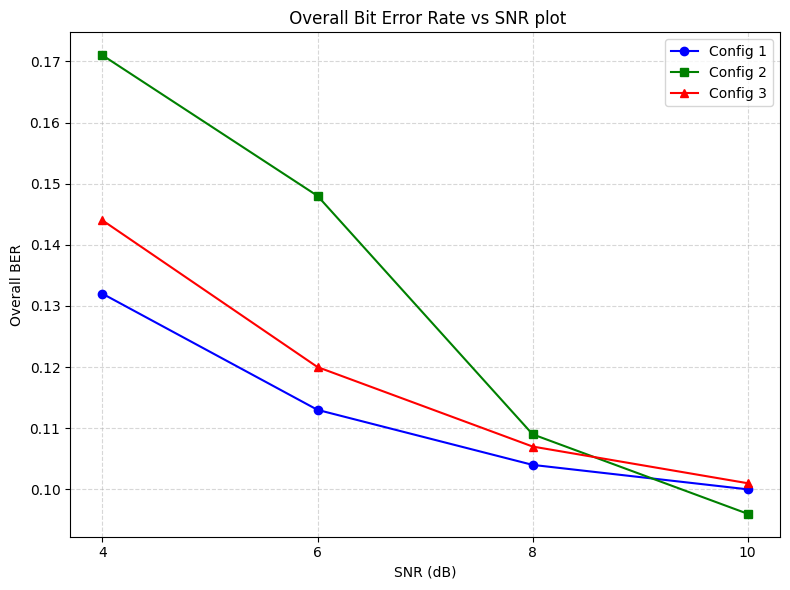

In [108]:


# --- JSON filenames ---
model_files = {
    "Config 1": "evaluation_model_config_3.json",
    "Config 2": "evaluation_model_config_4.json",
    "Config 3": "evaluation_model_config_5.json"
}

# --- Load all eval results ---
eval_results = {}
for model_name, file_name in model_files.items():
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"{file_name} not found in current directory")
    with open(file_name, 'r') as f:
        eval_results[model_name] = json.load(f)

# --- Extract SNRs (assume same SNRs across models) ---
snr_keys = sorted([int(k.split('_')[0]) for k in eval_results["Config 1"].keys()])
snrs = snr_keys  # e.g., [4,6,8,10]

# --- Prepare overall BER for each model ---
ber_values = {}
for model_name, results in eval_results.items():
    ber_values[model_name] = [results[f"{snr}_snr"]["overall_ber"] for snr in snrs]

# --- Plot ---
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for (model_name, ber), color, marker in zip(ber_values.items(), colors, markers):
    plt.plot(snrs, [round(b, 3) for b in ber], marker=marker, color=color, label=model_name)

plt.xlabel("SNR (dB)")
plt.ylabel("Overall BER")
plt.title(" Overall Bit Error Rate vs SNR plot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(snrs)
plt.tight_layout()
plt.show()


### Loss trend for Config 1 (3 actually)

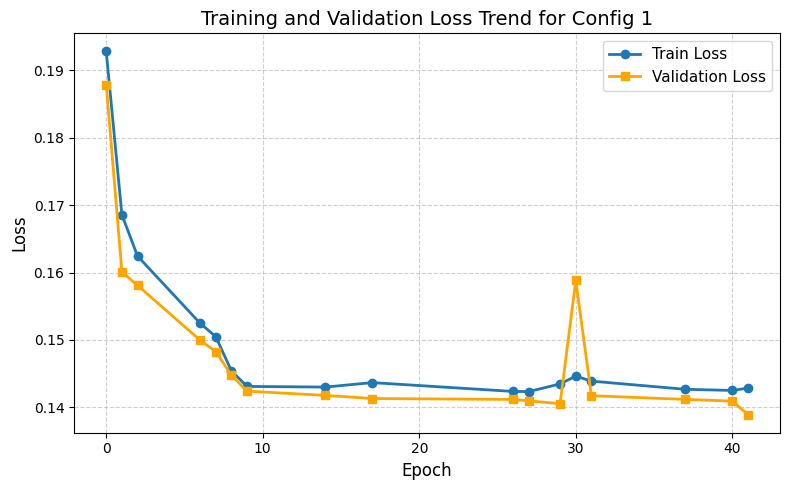

In [116]:
ckpt_dir = pathlib.Path("../checkpoints/config_3")  
pattern = re.compile(r"model_epoch_(\d+)\.pt$")

records = []


for ckpt_file in ckpt_dir.glob("model_epoch_*.pt"):
  
    m = pattern.search(ckpt_file.name)
    if not m:
        continue
    epoch = int(m.group(1))
    ckpt = torch.load(ckpt_file, map_location="cpu")
    train_loss = ckpt.get("train_loss")
   
    valid_loss = ckpt.get("val_loss")
    if train_loss is not None and valid_loss is not None:
        records.append((epoch, train_loss, valid_loss))



records.sort(key=lambda x: x[0])

epochs = [r[0] for r in records]
train_losses = [r[1] for r in records]

valid_losses = [r[2] for r in records]


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss', linewidth=2)
plt.plot(epochs, valid_losses, marker='s', label='Validation Loss', linewidth=2, color='orange')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Trend for Config 1", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()



### Msg Bit Size vs Net Bit Error Rate for Config 3

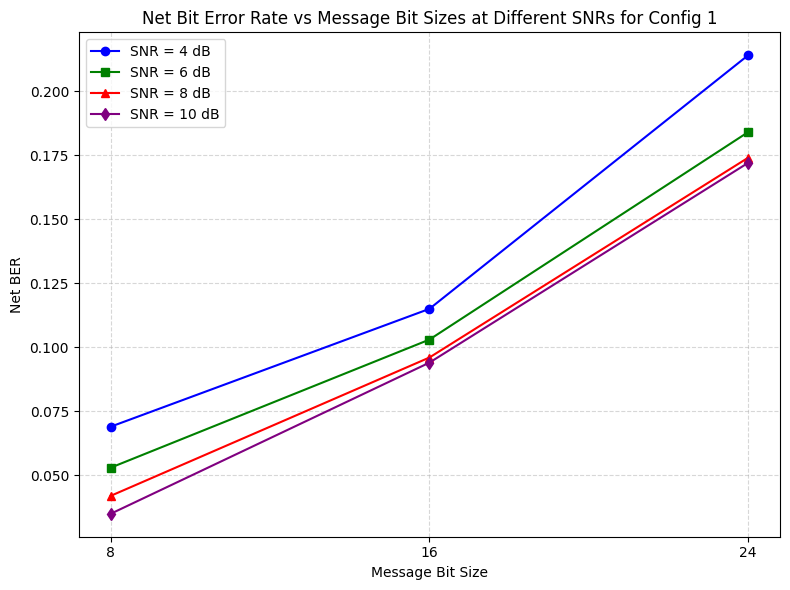

In [119]:



# --- Load JSON for config 3 ---
file_name = "evaluation_model_config_3.json"
if not os.path.exists(file_name):
    raise FileNotFoundError(f"{file_name} not found in current directory")

with open(file_name, 'r') as f:
    eval_data = json.load(f)

# --- Extract SNRs ---
snr_keys = sorted([int(k.split('_')[0]) for k in eval_data.keys() if "_snr" in k])

# --- Extract message bit sizes from one SNR entry (keys are strings) ---
first_snr_key = f"{snr_keys[0]}_snr"
message_bit_sizes = sorted([int(k) for k in eval_data[first_snr_key].keys() if k != "overall_ber"])

# --- Prepare data ---
ber_vs_msg_bits = {}
for snr in snr_keys:
    snr_key = f"{snr}_snr"
    # convert message bit size to string when accessing JSON
    ber_vs_msg_bits[snr] = [eval_data[snr_key][str(mb)]["average_net_bit_error_rate"] for mb in message_bit_sizes]

# --- Plot ---
plt.figure(figsize=(8,6))
markers = ['o','s','^','d','x']  # markers for multiple SNRs
colors = ['blue','green','red','purple','orange']

for idx, snr in enumerate(snr_keys):
    plt.plot(message_bit_sizes, 
             [round(b,3) for b in ber_vs_msg_bits[snr]], 
             marker=markers[idx%len(markers)], 
             color=colors[idx%len(colors)], 
             label=f"SNR = {snr} dB")

plt.xlabel("Message Bit Size")
plt.ylabel("Net BER")
plt.title("Net Bit Error Rate vs Message Bit Sizes at Different SNRs for Config 1")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(message_bit_sizes)
plt.legend()
plt.tight_layout()
plt.show()

